In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve, precision_score, recall_score

# The Data

In [4]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


# Part One: Fitting Models

## Q1: KNN

In [5]:
# Define x and y
X = ha.drop(columns=['output'])
y = ha['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CT
ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), make_column_selector(dtype_include=object)),  
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))  
])

# KNN and Grid Search
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='roc_auc')
pipeline_knn = Pipeline([('preprocessing', ct), ('knn', grid_search_knn)])

# Fit model
pipeline_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
roc_auc_knn = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Confusion matrix
y_pred_knn = best_knn.predict(X_test)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

roc_auc_knn, conf_matrix_knn

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


(0.709435817805383,
 array([[ 0, 26],
        [ 0, 29]]))

## Q2: Logistic Regression

In [8]:
lr = LogisticRegression()
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs']}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc')
pipeline_lr = Pipeline([('preprocessing', ct), ('lr', grid_search_lr)])

# Fit and evaluate the model
pipeline_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_
roc_auc_lr = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Confusion matrix
y_pred_lr = best_lr.predict(X_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

roc_auc_lr, conf_matrix_lr

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

(0.890139751552795,
 array([[ 2, 24],
        [ 0, 29]]))

## Q3: Decision Tree

In [9]:
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='roc_auc')
pipeline_dt = Pipeline([('preprocessing', ct), ('dt', grid_search_dt)])

# Fit and evaluate the model
pipeline_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
roc_auc_dt = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Confusion matrix
y_pred_dt = best_dt.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

roc_auc_dt, conf_matrix_dt

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


(0.8276695134575569,
 array([[ 0, 26],
        [ 0, 29]]))

## Q4: Interpretation

In [15]:
lr_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lr.coef_[0]
})
lr_coef['abs_coefficient'] = lr_coef['Coefficient'].abs()
lr_coef_sorted = lr_coef.sort_values('abs_coefficient', ascending=False)

# Decision Tree Feature Importances Interpretation
dt_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_dt.feature_importances_
})
dt_feature_importances_sorted = dt_feature_importances.sort_values('Importance', ascending=False)

lr_coef_sorted, dt_feature_importances_sorted

(   Feature  Coefficient  abs_coefficient
 6  thalach     1.318547         1.318547
 1      sex    -1.236675         1.236675
 2       cp     0.904306         0.904306
 0      age    -0.292293         0.292293
 4     chol    -0.276945         0.276945
 3   trtbps    -0.270870         0.270870
 5  restecg     0.041581         0.041581,
    Feature  Importance
 2       cp    0.568116
 6  thalach    0.210348
 1      sex    0.100022
 3   trtbps    0.060913
 0      age    0.060602
 4     chol    0.000000
 5  restecg    0.000000)

## Q5: ROC Curve

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


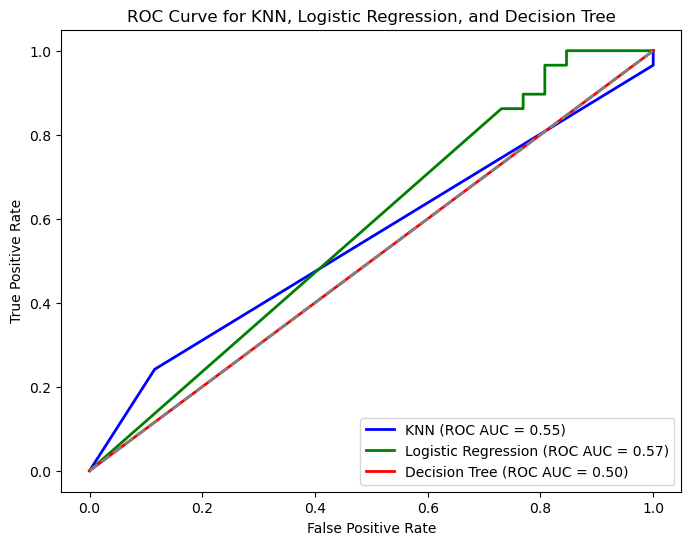

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each model using the test set
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for each model
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (ROC AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (ROC AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree (ROC AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN, Logistic Regression, and Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Part Two: Metrics

In [42]:
# KNN
from sklearn.metrics import make_scorer

# Using Reduced Feature Set
X = ha[['sex', 'cp', 'thalach', 'age']]

# Cross-validated metrics
tpr = cross_val_score(pipeline_knn, X, y, cv=10, scoring='recall').mean()

precision = cross_val_score(pipeline_knn, X, y, cv=10, scoring='precision').mean()

tnr_score = make_scorer(recall_score, pos_label=0) 
tnr = cross_val_score(pipeline_knn, X, y, cv=10, scoring=tnr_score).mean()

print("TPR:", tpr)
print("Precision:", precision)
print("TNR:", tnr)

TPR: 0.7671428571428571
Precision: 0.8067490842490843
TNR: 0.7878205128205127
TPR: 0.7671428571428571
Precision: 0.8067490842490843
TNR: 0.7878205128205127


In [47]:
# Using Reduced Feature Set
X = ha[['sex', 'cp', 'thalach', 'age', 'chol', 'trtbps']]

# Cross-validated metrics
tpr = cross_val_score(pipeline_lr, X, y, cv=10, scoring='recall').mean()

precision = cross_val_score(pipeline_lr, X, y, cv=10, scoring='precision').mean()

tnr_score = make_scorer(recall_score, pos_label=0)  
tnr = cross_val_score(pipeline_lr, X, y, cv=10, scoring=tnr_score).mean()

print("TPR:", tpr)
print("Precision:", precision)
print("TNR:", tnr)

TPR: 0.8290476190476191
Precision: 0.7846486928104575
TNR: 0.725
TPR: 0.8290476190476191
Precision: 0.7846486928104575
TNR: 0.725


In [49]:
# Using Reduced Feature Set
X = ha[['sex', 'cp']]

# Cross-validated metrics
tpr = cross_val_score(pipeline_dt, X, y, cv=10, scoring='recall').mean()

precision = cross_val_score(pipeline_dt, X, y, cv=10, scoring='precision').mean()

tnr_score = make_scorer(recall_score, pos_label=0)  
tnr = cross_val_score(pipeline_dt, X, y, cv=10, scoring=tnr_score).mean()

print("TPR:", tpr)
print("Precision:", precision)
print("TNR:", tnr)

TPR: 0.7404761904761905
Precision: 0.7691091588150412
TNR: 0.7403846153846154
TPR: 0.7404761904761905
Precision: 0.7691091588150412
TNR: 0.7403846153846154


# Part Three: Discussion

## Q1. The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.
Logistic regression should be used in this case because it has the highest True Positive Rate. This ensures the hospital to identify as many high risk patients as possible even though it may over predict.

## Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.
KNN should be used because it has the highest Precision, which ensures that patients predicted to be at high risk are more likely to actually need monitoring.

## Q3. The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.
Decision tree should be used because they provide clear insights into which features are most influential in making predictions.

## Q4. The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.
Logistic regression should be used because it has a good balance of True Positive Rate and Precision. It has the highest True Positive Rate and second highest Precision,

# Part Four: Validation

In [125]:
# Reading Validation Set
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [126]:
# KNN Prediction and Metrics
y_pred_knn = best_knn.predict(X_val)
conf_matrix_knn = confusion_matrix(y_val, y_pred_knn)
roc_auc_knn = roc_auc_score(y_val, best_knn.predict_proba(X_val)[:, 1])
precision_knn = precision_score(y_val, y_pred_knn)
tpr_knn = recall_score(y_val, y_pred_knn) 

# Logistic Regression Prediction and Metrics
y_pred_lr = best_lr.predict(X_val)
conf_matrix_lr = confusion_matrix(y_val, y_pred_lr)
roc_auc_lr = roc_auc_score(y_val, best_lr.predict_proba(X_val)[:, 1])
precision_lr = precision_score(y_val, y_pred_lr)
tpr_lr = recall_score(y_val, y_pred_lr)  

# Decision Tree Prediction and Metrics
y_pred_dt = best_dt.predict(X_val)
conf_matrix_dt = confusion_matrix(y_val, y_pred_dt)
roc_auc_dt = roc_auc_score(y_val, best_dt.predict_proba(X_val)[:, 1])
precision_dt = precision_score(y_val, y_pred_dt)
tpr_dt = recall_score(y_val, y_pred_dt)  

print("KNN Confusion Matrix:")
print(conf_matrix_knn)
print("KNN ROC AUC:", roc_auc_knn)
print("KNN Precision:", precision_knn)
print("KNN TPR:", tpr_knn)

print("\nLogistic Regression Confusion Matrix:")
print(conf_matrix_lr)
print("Logistic Regression ROC AUC:", roc_auc_lr)
print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression TPR:", tpr_lr)

print("\nDecision Tree Confusion Matrix:")
print(conf_matrix_dt)
print("Decision Tree ROC AUC:", roc_auc_dt)
print("Decision Tree Precision:", precision_dt)
print("Decision Tree TPR:", tpr_dt)

KNN Confusion Matrix:
[[ 3  8]
 [ 1 18]]
KNN ROC AUC: 0.6004784688995215
KNN Precision: 0.6923076923076923
KNN TPR: 0.9473684210526315

Logistic Regression Confusion Matrix:
[[11  0]
 [19  0]]
Logistic Regression ROC AUC: 0.6842105263157894
Logistic Regression Precision: 0.0
Logistic Regression TPR: 0.0

Decision Tree Confusion Matrix:
[[ 0 11]
 [ 0 19]]
Decision Tree ROC AUC: 0.5
Decision Tree Precision: 0.6333333333333333
Decision Tree TPR: 1.0
KNN Confusion Matrix:
[[ 3  8]
 [ 1 18]]
KNN ROC AUC: 0.6004784688995215
KNN Precision: 0.6923076923076923
KNN TPR: 0.9473684210526315

Logistic Regression Confusion Matrix:
[[11  0]
 [19  0]]
Logistic Regression ROC AUC: 0.6842105263157894
Logistic Regression Precision: 0.0
Logistic Regression TPR: 0.0

Decision Tree Confusion Matrix:
[[ 0 11]
 [ 0 19]]
Decision Tree ROC AUC: 0.5
Decision Tree Precision: 0.6333333333333333
Decision Tree TPR: 1.0


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

True positive rate is higher with all of them being for KNN and Decision Tree  with everything else being lower compared to Part One and Two.

# Part Five: Cohen’s Kappa

In [127]:
from sklearn.metrics import cohen_kappa_score

# KNN
knn_kappa = cohen_kappa_score(y_test, y_pred_knn)

# Logistic Regression
lr_kappa = cohen_kappa_score(y_test, y_pred_lr)

# Decision Tree
dt_kappa = cohen_kappa_score(y_test, y_pred_dt)

# Output the results
print(f"KNN Model - Cohen's Kappa: {knn_kappa}")
print(f"Logistic Regression Model - Cohen's Kappa: {lr_kappa}")
print(f"Decision Tree Model - Cohen's Kappa: {dt_kappa}")

KNN Model - Cohen's Kappa: 0.2541436464088398
Logistic Regression Model - Cohen's Kappa: 0.0
Decision Tree Model - Cohen's Kappa: 0.0
KNN Model - Cohen's Kappa: 0.2541436464088398
Logistic Regression Model - Cohen's Kappa: 0.0
Decision Tree Model - Cohen's Kappa: 0.0


Cohen's Kappa values are low, which indicates that the models are underperforming or about the same as making a guess.While ROC AUC may show better results, Cohen's Kappa highlights the need for improvement. This could be due to class imbalance or the need for further model tuning.